### Lectura de imagen e inicializacion de variables

8392704


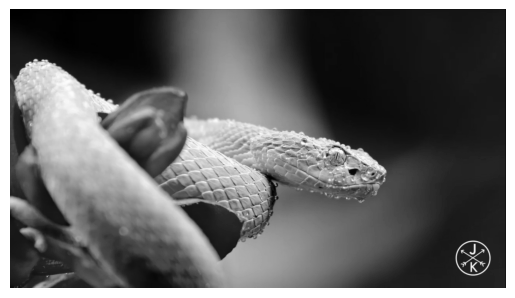

In [27]:
#Lectura de la imagen e inicializacion de variables
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import numpy as np # type: ignore
import math
from scipy import signal # type: ignore
from skimage.color import rgb2gray # type: ignore

qam16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j,  
                          -1-3j, -1-1j, -1+3j, -1+1j,  
                           3-3j,  3-1j,  3+3j,  3+1j,  
                           1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)

qpsk = np.array([1+1j, -1+1j, 1-1j, -1-1j]) / np.sqrt(2)

constelaciones = {
    'QPSK': qpsk,
    '16-QAM': qam16,
}


#Parámetros 
Modulacion = '16-QAM' #Modulacion
BW = 10 #Ancho de banda en MHz
Referencia = 4+4j
Antenas = 4
# Leer la imagen
imagena = mpimg.imread("Frame1.jpg")
imagen = rgb2gray(imagena)*255
datos_array = np.array(imagen, dtype=np.uint8)
datos = np.unpackbits(datos_array.flatten())

# Mostrar el número total de bits
# Mostrar la imagen original
print(len(datos))
plt.imshow(datos_array,cmap='gray')
plt.axis('off')
plt.show()

### Modulacion QPSK, 16-QAM

In [28]:
#Modulacion QPSK, 16-QAM, 64-QAM
def generarSimbolos(datos, modulacion):
    longitud = len(datos)
    
    # Verificación de longitud válida
    if longitud % (2 if modulacion == 'QPSK' else 4 if modulacion == '16-QAM' else 6) != 0:
        raise ValueError(f"Longitud de datos incompatible con la modulación {modulacion}")
    
    if modulacion == 'QPSK':
        # 2 bits por símbolo
        datos = np.array(datos).reshape(-1, 2)
        indices = datos.dot(1 << np.arange(2)[::-1])  # Mapea los bits a índices
        simbolos = qpsk[indices]

    elif modulacion == '16-QAM':
        # 4 bits por símbolo
        datos = np.array(datos).reshape(-1, 4)
        indices = datos.dot(1 << np.arange(4)[::-1])  # Mapea los bits a índices
        simbolos = qam16[indices]
    else: 
        raise Exception('Solo de QPSK a 16QAM.')
    
    return simbolos

nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = generarSimbolos(datos,Modulacion)
print(len(modulado))
#for i in range(6,nSubportadoras,12):
#    modulado = np.insert(modulado, i, Referencia)
#3197952
nSimbolos = len(modulado)+nBloques
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)
print('Número de bloques de recursos:',nBloques)
print('Número de subportadoras:',nSubportadoras)
print('Número de símbolos a enviar:',nSimbolos)
print('Número de símbolos OFDM:',nSimbolosOFDM)

2098176
Número de bloques de recursos: 56
Número de subportadoras: 672
Número de símbolos a enviar: 2098232
Número de símbolos OFDM: 3123


### Calculo de la FFT

In [29]:
#FFT
M = 2**math.ceil(math.log2(nSubportadoras))
N = 2*M

datosFFT = np.zeros(nSimbolosOFDM * M, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM


for i in range(nSimbolosOFDM):
    scArray = np.zeros(M, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(modulado[j:j+nSubportadoras])
        if longitud < nSubportadoras:
            scArray[0:nSubportadoras] = np.concatenate((modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
        else:
            scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    else:
        scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras] 
    datosFFT[k:k + M] = np.fft.fft(scArray, M)  # Aplicar FFT
    # Incrementar los índices
    j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
    k = k + M  # Incrementar el índice para los datos OFDM
#print(len(datosFFT))   
a= datosFFT
for i in range(6,M,12):
    datosFFT = np.insert(datosFFT, i, Referencia)

print(len(datosFFT))
#print(datosFFT[0:20])

3198037


### Modulacion OFDM

In [30]:
#Modulacion OFDM
datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM

for i in range(nSimbolosOFDM):
    scArray = np.zeros(N, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(datosFFT[j:])
        if longitud < M:
            scArray[0:M] = np.concatenate((datosFFT[j:j+M],np.zeros(M-longitud)))
        else:
            scArray[0:M] = datosFFT[j:j+M]
    else:
        scArray[0:M] = datosFFT[j:j+M]  # Asignar los datos a las subportadoras correspondientes utilizando los índices calculados anteriormente
    # Realizar la modulación IFFT
    datosOFDMsr = np.fft.ifft(np.fft.fftshift(scArray), N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
    datosOFDM[k:k + N] = datosOFDMsr
    # Incrementar los índices
    j = j + M  # Incrementar el índice para los datos de entrada
    k = k + N  # Incrementar el índice para los datos OFDM
print(len(datosOFDM))


6395904


### Prefijo ciclico

In [31]:
# Define la función para agregar el prefijo cíclico (CP)
def anadirPrefijo(simboloOfdm, N, longitudCP):
    # Extraer el CP (las últimas longitudCP muestras del símbolo OFDM)
    cp = simboloOfdm[N - longitudCP:N:1]
    
    # Concatenar el CP y el símbolo OFDM
    simboloOfdm_cp = np.concatenate((cp, simboloOfdm))
    
    return simboloOfdm_cp

longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
j = 0
k = 0

for i in range(nSimbolosOFDM):
    # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
    ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[j:j + N], N, longitudCP)
    
    # Incrementar los índices para la siguiente iteración
    j = j + N
    k = k + N + longitudCP

### Efectos del canal

In [32]:
#Efectos del canal
def awgn(senal,SNR):
        # Measure signal power 
        potenciaSenal = np.mean(abs(senal)**2)

        # Calculate noise power 
        potenciaRuido = potenciaSenal/(10 **(SNR/10))
        
        # Generate complex noise 
        noise = np.sqrt(potenciaRuido/2)*(np.random.randn(len(senal)) + np.random.randn(len(senal))*1j)
        
        # Add signal and noise 
        senalRuidosa = senal + noise 
        
        return senalRuidosa, potenciaRuido

# Aplicación del primer canal multicamino
nCaminos = 2
SNR = 10 # Desired SNR (dB) 
h = []
Noise = []
Senal_Rx = []
for i in range(Antenas):
    h1 = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
    # Aplicar filtro del canal 
    canal1 = np.fft.fftshift(np.fft.fft(h1,N))
    h.append(canal1)
    Senal_mp = np.convolve(ofdmConCP,h1)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]
    Senal_awgn ,N1 = awgn(Senal_mp,SNR)
    Noise.append(N1)
    Senal_Rx.append(Senal_awgn)


### Demodulacion OFDM

0.20736988
0.20326054
0.34465548
0.24471411


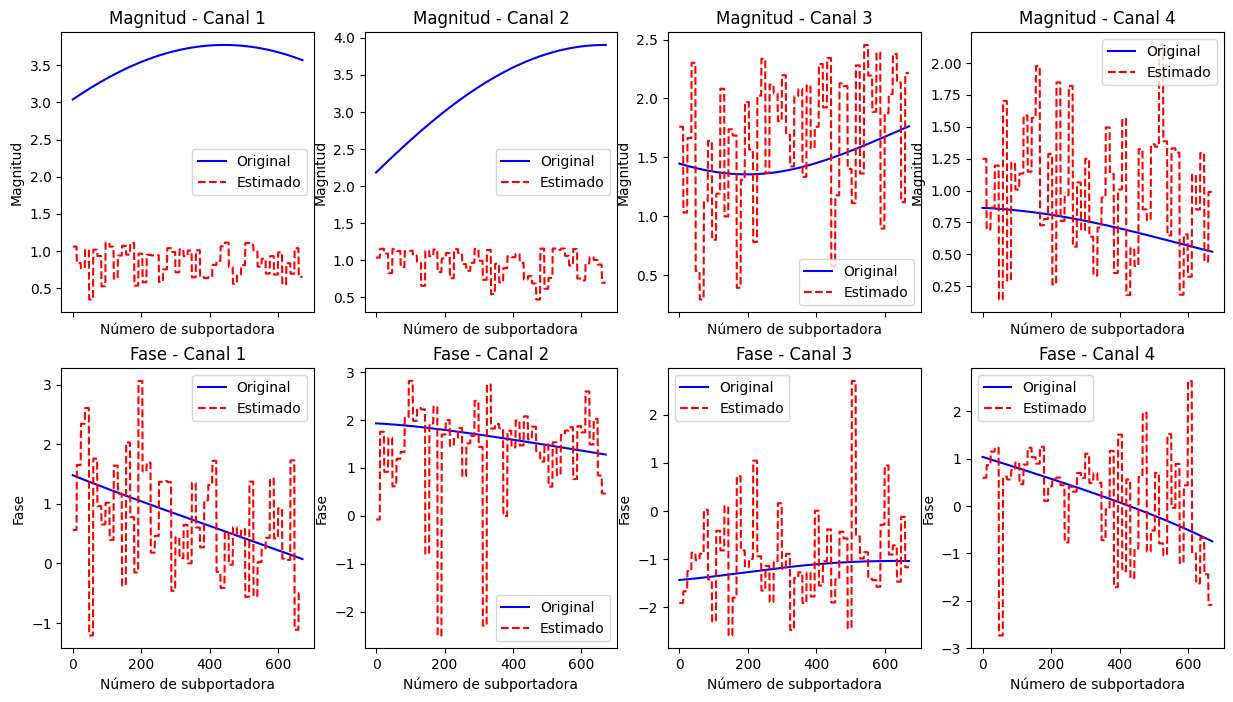

In [33]:
#Demodulacion OFDM
def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fftshift(np.fft.fft(ofdmSinPrefijo, N))
    #print(data[1020:1030])
    return data[0:M]


# Array para almacenar los símbolos de datos recuperados
rxDatos = []
canales = []
for antena in range(Antenas):
    rxDatosn = np.zeros(nSimbolosOFDM*M, np.complex64)
    estimado_rxn = []
    j = 0
    k = 0 
    x = 0

    L = len(Senal_Rx[antena])
    Referencias_rx1 = []
    for i in range(nSimbolosOFDM):
        rx_demod = demodulacionOFDM(Senal_Rx[antena][k:(k + N + longitudCP)], N, longitudCP)
        if i == 0:        
            for l in range(M):
                if l%12 == 6:
                    if l < M:
                        Referencias_rx1.append(rx_demod[l])
                    x += 1
                else:
                    rxDatosn[l-x]=rx_demod[l]
            j = j + l - x + 1
            if len(Referencias_rx1) < M/12:
                Referencias_rx1 = np.concatenate((Referencias_rx1,np.array([1])))
            for l in range(M):
                estimado_rxn.append(Referencias_rx1[l//12])
            estimacion_canal1 = np.zeros(len(estimado_rxn),np.complex64)
            for l in range(len(estimacion_canal1)):
                estimado1 = Referencia/estimado_rxn[l]
                estimacion_canal1[l] = estimado1.conjugate()/(Noise[antena]+abs(estimado1)**2)
        else:
            if i == (nSimbolosOFDM-1):
                rxDatosn[j:j + M] = rx_demod[0:(len(rxDatosn)-j)]/estimacion_canal1[0:(len(rxDatosn)-j)]
            else:
                rxDatosn[j:j + M] = rx_demod/estimacion_canal1
        
        # Actualizar los índices para la siguiente iteración
            j = j + M
        k = k + N + longitudCP
    rxDatos.append(rxDatosn)
    canales.append(estimacion_canal1)
rxDatosf = np.copy(rxDatos[0])
mDatos = np.array(rxDatos)
mcanales = np.array(canales)
promedios = np.mean(mDatos, axis=0)
rxDatosf=list(promedios)

for i in range(len(canales[0])):
    suma = np.sum(abs(mcanales[:,i]))
    valor = 0
    for antena in range(Antenas):
        valor += (mcanales[antena,i]/suma)*mDatos[antena,i] 
        if i == 1:
            print(abs((mcanales[antena,i]/suma)))
    rxDatosf[i] = valor


if len(canales) <= 4:
    fig, axs = plt.subplots(2, Antenas, figsize=(15, 8), sharex=True)
    for antena in range(Antenas):
        axs[0, antena].plot(abs(h[antena])[0:nSubportadoras], 'b', label='Original')
        axs[0, antena].plot(abs(canales[antena])[0:nSubportadoras], '--r', label='Estimado')
        axs[0, antena].set_title(f'Magnitud - Canal {antena+1}')
        axs[0, antena].set_xlabel('Número de subportadora')
        axs[0, antena].set_ylabel('Magnitud')
        axs[0, antena].legend()

        axs[1, antena].plot(np.angle(h[antena])[0:nSubportadoras], 'b', label='Original')
        axs[1, antena].plot(np.angle(canales[antena])[0:nSubportadoras], '--r', label='Estimado')
        axs[1, antena].set_title(f'Fase - Canal {antena+1}')
        axs[1, antena].set_xlabel('Número de subportadora')
        axs[1, antena].set_ylabel('Fase')
        axs[1, antena].legend()
else:
    fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    for antena in range(3):
        axs[0, antena].plot(abs(h[antena])[0:nSubportadoras], 'b', label='Original')
        axs[0, antena].plot(abs(canales[antena])[0:nSubportadoras], '--r', label='Estimado')
        axs[0, antena].set_title(f'Magnitud - Canal {antena+1}')
        axs[0, antena].set_xlabel('Número de subportadora')
        axs[0, antena].set_ylabel('Magnitud')
        axs[0, antena].legend()

        axs[1, antena].plot(np.angle(h[antena])[0:nSubportadoras], 'b', label='Original')
        axs[1, antena].plot(np.angle(canales[antena])[0:nSubportadoras], '--r', label='Estimado')
        axs[1, antena].set_title(f'Fase - Canal {antena+1}')
        axs[1, antena].set_xlabel('Número de subportadora')
        axs[1, antena].set_ylabel('Fase')
        axs[1, antena].legend()


### Demodulacion primera señal (para comparacion)

In [34]:
#Demodulacion de una sola señal para comparar
rxDatos1 = rxDatos[0]
datosIFFT1 = np.zeros(nSimbolos-nBloques, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM

for i in range(nSimbolosOFDM):
    scArray = np.zeros(M, np.complex64)
    scArray = np.fft.ifft(rxDatos1[j:j+M],M)
    if i == (nSimbolosOFDM-1):
        longitud=len(datosIFFT1[k:k+nSubportadoras])
        if longitud < nSubportadoras:
            datosIFFT1[k:k + nSubportadoras] = scArray[0:longitud] 
        else:
            datosIFFT1[k:k + nSubportadoras] = scArray[0:nSubportadoras] 
    else:        
        datosIFFT1[k:k + nSubportadoras] = scArray[0:nSubportadoras] 
    # Incrementar los índices
    j = j + M  # Incrementar el índice para los datos de entrada
    k = k + nSubportadoras  # Incrementar el índice para los datos OFDM

def decision_vectorizada(modulado, matriz):
    # Calcular todas las distancias en una sola operación vectorizada
    distancias = np.abs(modulado[:, np.newaxis] - matriz)  # Broadcasting para calcular distancias
    indices = np.argmin(distancias, axis=1)  # Encuentra los índices de las distancias mínimas
    # Convertir los índices a binario de forma vectorizada
    bits = np.array([list(np.binary_repr(i, width=int(np.log2(len(matriz))))) for i in indices], dtype=int)
    return bits.flatten()  # Devolver como un solo vector plano

if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

# Aplicar la función de decisión a todos los valores modulados de una vez
dataSombrero1 = decision_vectorizada(datosIFFT1, constelacion)

### Calculo de la IFFT

In [35]:
#IFFT
datosIFFT = np.zeros(nSimbolos-nBloques, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM

for i in range(nSimbolosOFDM):
    scArray = np.zeros(M, np.complex64)
    scArray = np.fft.ifft(rxDatosf[j:j+M],M)
    if i == (nSimbolosOFDM-1):
        longitud=len(datosIFFT[k:k+nSubportadoras])
        if longitud < nSubportadoras:
            datosIFFT[k:k + nSubportadoras] = scArray[0:longitud] 
        else:
            datosIFFT[k:k + nSubportadoras] = scArray[0:nSubportadoras] 
    else:        
        datosIFFT[k:k + nSubportadoras] = scArray[0:nSubportadoras] 
    # Incrementar los índices
    j = j + M  # Incrementar el índice para los datos de entrada
    k = k + nSubportadoras  # Incrementar el índice para los datos OFDM


print(len(datosIFFT))

2098176


In [36]:
if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

# Aplicar la función de decisión a todos los valores modulados de una vez
dataSombrero = decision_vectorizada(datosIFFT, constelacion)

8392704


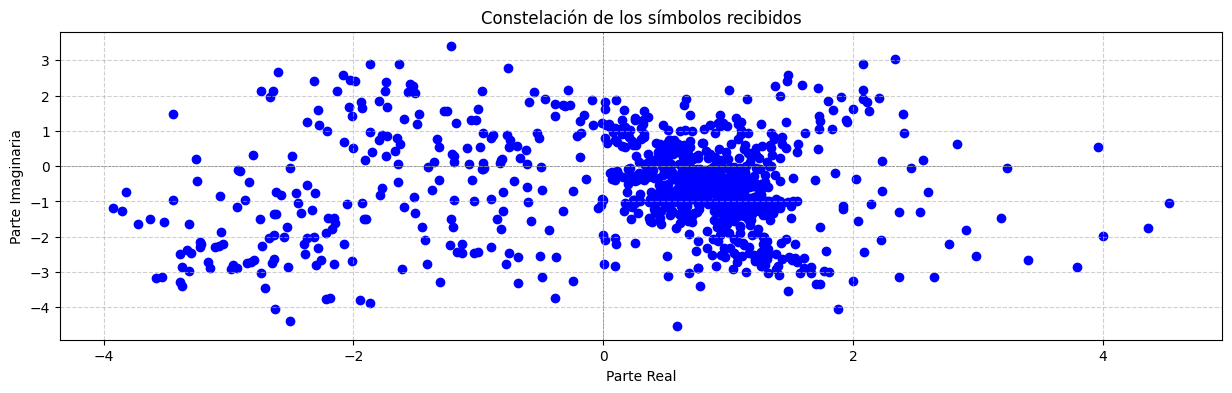

In [37]:
print(len(dataSombrero))
grafica = datosIFFT[0:1000]

plt.figure(figsize=(15, 4))  # Cuadrar para que sea proporcional
plt.scatter(grafica.real, grafica.imag, color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Constelación de los símbolos recibidos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Calculo del BER

In [38]:
def calcular_BER(bits_reales, bits_recibidos):
    if len(bits_reales) != len(bits_recibidos):
        raise ValueError("Los vectores deben tener la misma longitud")
    
    # Calcular el número de bits en error
    errores = np.sum(bits_reales != bits_recibidos)
    
    # Calcular la Tasa de Error de Bit (BER)
    ber = errores / len(bits_reales)
    return ber

print("BER una sola señal",calcular_BER(datos,dataSombrero1))
print("BER señal combinada",calcular_BER(datos,dataSombrero))

BER una sola señal 0.2841734916422645
BER señal combinada 0.21329168763726208


### Grafica recibida

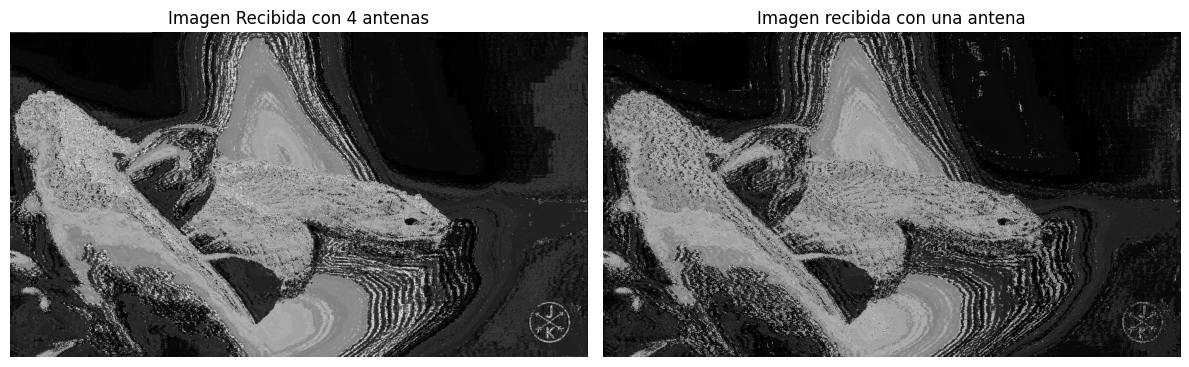

In [39]:
#Grafica recibida
datos_rx = dataSombrero
datos_rx1 = dataSombrero1

bits_array = np.array(datos_rx, dtype=np.uint8)
num_bytes = bits_array.size // 8  # Cantidad de bytes necesarios
bytes_array = bits_array[:num_bytes * 8].reshape(-1, 8)
bits_array1 = np.array(datos_rx1, dtype=np.uint8)
num_bytes1 = bits_array1.size // 8  # Cantidad de bytes necesarios
bytes_array1 = bits_array1[:num_bytes1 * 8].reshape(-1, 8)

# Convertir los grupos de 8 bits en valores enteros de 0 a 255 (uint8)
pixels_array = np.packbits(bytes_array)
pixels_array1 = np.packbits(bytes_array1)

# Reconstruir la imagen a partir de los píxeles
# Primero, debemos saber la forma original de la imagen
dimension_original = (768, 1366)  # Asegúrate de usar las dimensiones correctas
imagen_recuperada = pixels_array.reshape(dimension_original)
imagen_recuperada1 = pixels_array1.reshape(dimension_original)

# Mostrar la imagen recuperada
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
axes[0].imshow(imagen_recuperada, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f'Imagen Recibida con {Antenas} antenas')

# Gráfica 2
axes[1].imshow(imagen_recuperada1, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Imagen recibida con una antena')

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()